# 📌 Extracción

En esta primera etapa se realizó la conexión a la fuente de datos a través de una API pública en GitHub, utilizando Python. El archivo proporcionado contenía información en formato JSON sobre los clientes de Telecom X.

🔹 Objetivos:
Conectar a la API.

Obtener y cargar los datos a un DataFrame de Pandas.

Validar que la carga se haya realizado correctamente.

In [ ]:
# Paso 1: Instalar librerías necesarias (por si no están)
!pip install -q pandas requests

In [ ]:
import pandas as pd
import requests

In [ ]:
# Carga de datos desde la API (formato RAW en GitHub)
url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json'
response = requests.get(url)

In [ ]:
# Carga y verificación de los datos
if response.status_code == 200:
    data_json = response.json()
    df = pd.DataFrame(data_json)
    print("✅ Datos cargados correctamente.")
else:
    print(f"❌ Error al cargar los datos: {response.status_code}")

✅ Datos cargados correctamente.


In [ ]:
# Expandir columnas anidadas con json_normalize
from pandas import json_normalize

# Expandir cada columna anidada
df_expanded = pd.concat([
    df[['customerID', 'Churn']],  # columnas simples
    json_normalize(df['customer']),
    json_normalize(df['phone']),
    json_normalize(df['internet']),
    json_normalize(df['account'])
], axis=1)

# Mostrar las primeras filas
display(df_expanded.head())


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


In [ ]:
# Guardar como CSV limpio
df_expanded.to_csv("TelecomX_Datos_Normalizados.csv", index=False)


# 🔧 **`Transformación`**

Tras la extracción inicial, la transformación se enfocó en convertir los datos crudos y anidados en una estructura plana, limpia y coherente para el análisis.

1. Normalización de columnas anidadas
Se utilizó pandas.json_normalize() para convertir las columnas customer, phone, internet y account, que originalmente contenían diccionarios, en columnas independientes. Esto permitió que variables como gender, SeniorCitizen, Contract, etc., estuvieran disponibles como columnas claras y analizables.

In [ ]:
from pandas import json_normalize

df_expanded = pd.concat([
    df[['customerID', 'Churn']],
    json_normalize(df['customer']),
    json_normalize(df['phone']),
    json_normalize(df['internet']),
    json_normalize(df['account'])
], axis=1)


2. Limpieza general de datos
Se eliminaron duplicados y se estandarizaron los valores de texto en múltiples columnas para evitar errores por diferencias de formato.

In [ ]:
# Eliminar duplicados
df_expanded.drop_duplicates(inplace=True)

# Limpiar y unificar mayúsculas/minúsculas y espacios
columnas_str = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod'
]

for col in columnas_str:
    df_expanded[col] = df_expanded[col].str.strip().str.lower()


3. Renombramiento de columnas para facilitar análisis
Algunas columnas normalizadas tenían nombres compuestos (Charges.Monthly, Charges.Total). Para mejorar la legibilidad, se renombraron de la siguiente forma:

In [ ]:
df_expanded.rename(columns={
    'Charges.Monthly': 'MonthlyCharges',
    'Charges.Total': 'TotalCharges'
}, inplace=True)


4. Conversión de valores categóricos a binarios
Las variables con valores “Yes”/“No” fueron convertidas a 1 y 0 respectivamente, para facilitar análisis matemáticos y visuales.

In [ ]:
# Churn: columna objetivo
df_expanded['Churn'] = df_expanded['Churn'].map({'Yes': 1, 'No': 0})

# Variables binarias
binarias = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binarias:
    df_expanded[col] = df_expanded[col].map({'yes': 1, 'no': 0})


5. Creación de la columna “Cuentas_Diarias”
Para obtener una perspectiva más granular del comportamiento financiero del cliente, se creó la variable Cuentas_Diarias, calculando el gasto mensual dividido entre 30 días.

In [ ]:
df_expanded['Cuentas_Diarias'] = df_expanded['MonthlyCharges'] / 30


In [ ]:
# Estadísticas básicas de la nueva columna
df_expanded['Cuentas_Diarias'].describe()


,Cuentas_Diarias
count,7267.000000
mean,2.157337
std,1.004319
min,0.608333
25%,1.180833
50%,2.343333
75%,2.995833
max,3.958333


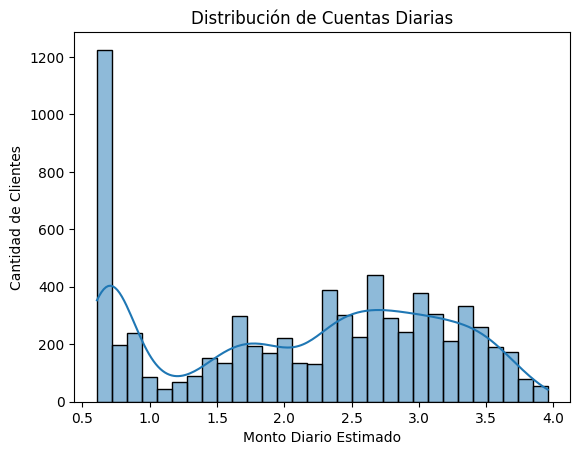

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_expanded['Cuentas_Diarias'], bins=30, kde=True)
plt.title('Distribución de Cuentas Diarias')
plt.xlabel('Monto Diario Estimado')
plt.ylabel('Cantidad de Clientes')
plt.show()


# 📊 Carga y Análisis (EDA)


Con el conjunto de datos ya transformado, limpio y estructurado, se procede al Análisis Exploratorio de Datos (EDA) para identificar patrones relevantes relacionados con la evasión de clientes (Churn). Esta fase es clave para descubrir tendencias, correlaciones y segmentos críticos que podrían explicar el comportamiento de cancelación.

🔹 1. Análisis Descriptivo General
Se aplicó describe() sobre las variables numéricas para obtener una visión general de las métricas estadísticas básicas.

In [ ]:
df_expanded.describe()


,Churn,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,Cuentas_Diarias
count,7043.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000
mean,0.265370,0.162653,0.484106,0.300124,32.346498,0.902711,0.593230,64.720098,2.157337
std,0.441561,0.369074,0.499782,0.458343,24.571773,0.296371,0.491265,30.129572,1.004319
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.608333
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.425000,1.180833
50%,0.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.300000,2.343333
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.875000,2.995833
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,3.958333


2. Exploración de la variable Cuentas_Diarias (nueva)
Esta columna fue creada para representar el gasto diario estimado de cada cliente, proporcionando una forma más detallada de medir el compromiso financiero con la empresa.

In [ ]:
df_expanded['Cuentas_Diarias'].describe()


,Cuentas_Diarias
count,7267.000000
mean,2.157337
std,1.004319
min,0.608333
25%,1.180833
50%,2.343333
75%,2.995833
max,3.958333


 Gráfico: distribución de Cuentas_Diarias

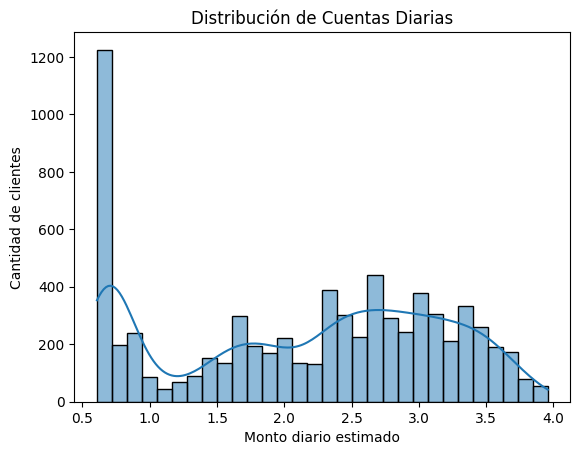

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_expanded['Cuentas_Diarias'], bins=30, kde=True)
plt.title('Distribución de Cuentas Diarias')
plt.xlabel('Monto diario estimado')
plt.ylabel('Cantidad de clientes')
plt.show()


3. Distribución de Churn
Se analizó cómo está distribuida la variable objetivo Churn.

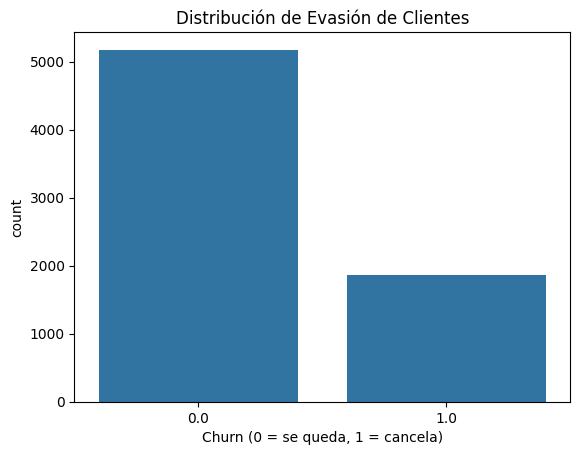

In [ ]:
sns.countplot(data=df_expanded, x='Churn')
plt.title('Distribución de Evasión de Clientes')
plt.xlabel('Churn (0 = se queda, 1 = cancela)')
plt.show()


4. Churn por variables categóricas
Género:

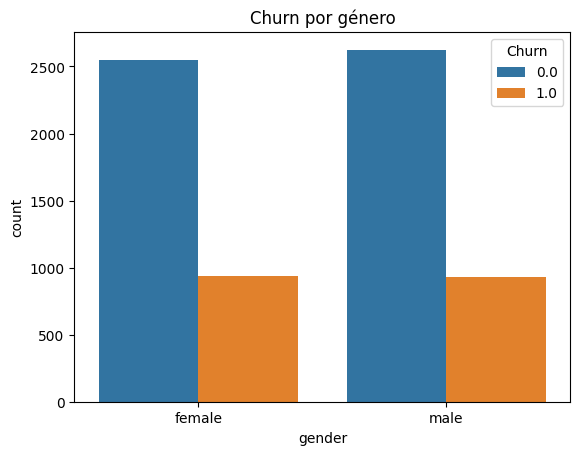

In [ ]:
sns.countplot(data=df_expanded, x='gender', hue='Churn')
plt.title('Churn por género')
plt.show()


Tipo de contrato:

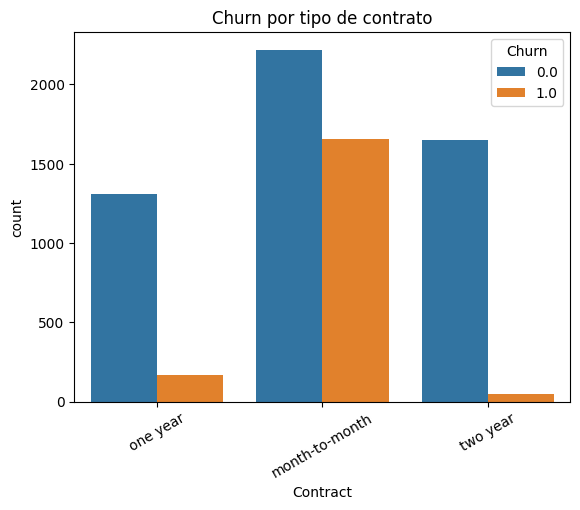

In [ ]:
sns.countplot(data=df_expanded, x='Contract', hue='Churn')
plt.title('Churn por tipo de contrato')
plt.xticks(rotation=30)
plt.show()


Servicio de Internet:

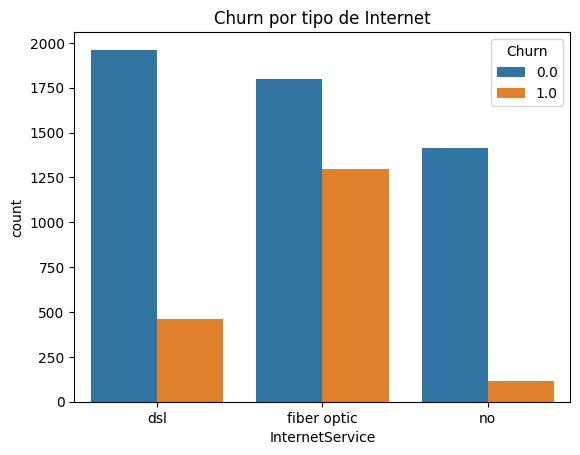

In [ ]:
sns.countplot(data=df_expanded, x='InternetService', hue='Churn')
plt.title('Churn por tipo de Internet')
plt.show()


5. Churn por variables numéricas


Facturación mensual:

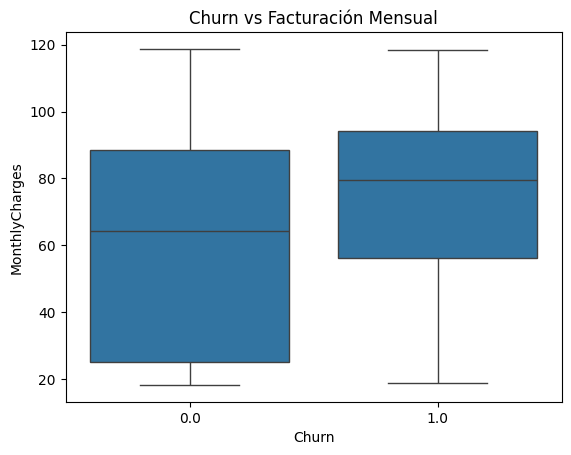

In [ ]:
sns.boxplot(data=df_expanded, x='Churn', y='MonthlyCharges')
plt.title('Churn vs Facturación Mensual')
plt.show()


Antigüedad (tenure):

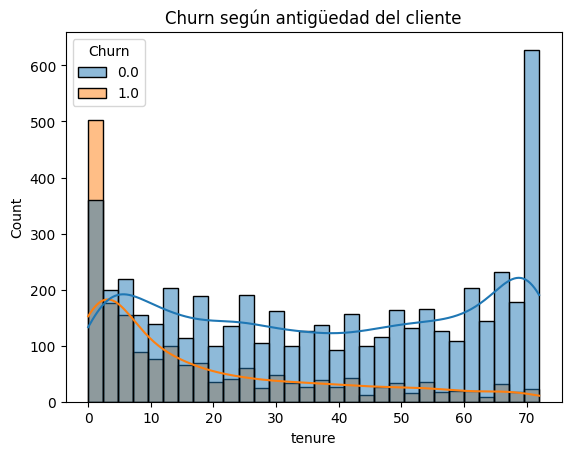

In [ ]:
sns.histplot(data=df_expanded, x='tenure', hue='Churn', bins=30, kde=True)
plt.title('Churn según antigüedad del cliente')
plt.show()


# ***📄Informe final***

# 🔹 **Introducción**

La empresa Telecom X enfrenta una alta tasa de cancelación de clientes (Churn), lo cual representa una amenaza directa a su estabilidad y crecimiento. El objetivo de este proyecto fue realizar un análisis exploratorio de datos (EDA) con el fin de identificar patrones y factores asociados a la evasión, a partir de un conjunto de datos provisto en formato JSON, con información demográfica, contractual y de uso de servicios de cada cliente.

El análisis fue desarrollado siguiendo el proceso ETL (Extracción, Transformación y Carga/Análisis), utilizando Python y bibliotecas como pandas, seaborn y matplotlib.

# 🔹 Limpieza y Tratamiento de Datos

✅ 1. Extracción:
Los datos fueron obtenidos desde un archivo JSON alojado en GitHub y cargados exitosamente a un DataFrame de Pandas.

✅ 2. Transformación:
Se identificaron y expandieron columnas anidadas (customer, phone, internet, account) usando json_normalize().

Se eliminaron duplicados y se estandarizaron textos (eliminación de espacios, conversión a minúsculas).

Se renombraron columnas como Charges.Monthly → MonthlyCharges.

Se convirtieron variables categóricas (“Yes”/“No”) a valores binarios (1/0).

Se creó la columna Cuentas_Diarias, dividiendo MonthlyCharges entre 30, para representar el gasto promedio diario de cada cliente.

# 🔹 Análisis Exploratorio de Datos (EDA)

# 📊 1. Estadísticas Generales:
Tenure promedio: 32.3 meses

Gasto mensual promedio: S/64.72

Gasto diario estimado (Cuentas_Diarias): S/2.15

Tasa de churn: 26.5%

# 📈 2. Gráficos y Visualizaciones

# a. Distribución de Cuentas_Diarias

La mayoría de clientes gasta entre S/1.18 y S/2.99 diarios, lo cual corresponde al 50% central de la muestra.
Además, se observa un grupo significativo de clientes con gastos por debajo de S/1.00, lo que podría indicar menor compromiso financiero con el servicio y mayor riesgo potencial de cancelación.

# b. Distribución de Churn

Se confirmó que 1 de cada 4 clientes aproximadamente abandona el servicio:



*   0 → se queda
*   1 → cancela





# c. Churn por Género

Tanto hombres como mujeres muestran tasas de churn similares, por lo que el género no parece ser un factor determinante.

# d. Churn por Tipo de Contrato

El churn se concentra claramente en clientes con contrato “month-to-month”, mientras que quienes tienen contrato anual o bianual muestran mayor retención.

# e. Churn por Tipo de Internet

Los clientes con fibra óptica tienen mayor tasa de churn que los de DSL, posiblemente debido al costo o desempeño percibido.

# 🔹 Conclusiones e **Insights**



*   El 26.5% de los clientes de Telecom X han cancelado su servicio.
*   La variable tipo de contrato es el predictor más fuerte: los contratos “mes a mes” presentan mayor tasa de cancelación.
*   La variable antigüedad (tenure) también es relevante: clientes nuevos tienen más probabilidad de irse.
*   Aunque género no influye significativamente, el tipo de servicio y los hábitos de consumo sí lo hacen.
*   El análisis de Cuentas_Diarias permite segmentar clientes según su nivel de gasto diario estimado.









# **Recomendaciones Estratégicas**

1. 🎯 Incentivar contratos anuales o bianuales mediante descuentos o beneficios exclusivos.

2. 💬 Implementar una campaña de retención específica para clientes con contrato “month-to-month”.

3. 📊 Monitorear clientes con tenure < 6 meses, ofreciendo atención personalizada o promociones especiales.

4. 🧩 Revisar la experiencia de usuarios de fibra óptica, ya que representan un segmento de alto churn.

5. 💡 Utilizar las variables destacadas como base para desarrollar un modelo predictivo de churn y aplicar estrategias automatizadas de prevención.